# Load subject data

In [3]:
import os
import numpy as np
import pandas as pd

# define data root
roamm_root = r"/gpfs1/pi/djangraw/mindless_reading/ROAMM"
ml_data_root = os.path.join(roamm_root, 'subject_ml_data')
# define subject id
subject_id = 's10014'
subject_dir = os.path.join(ml_data_root, subject_id, 'window_datasets')

# load windowed data and labels
window_size = 256
data_file = os.path.join(subject_dir, f'{subject_id}_{window_size}windowed_data.npy')
label_file = os.path.join(subject_dir, f'{subject_id}_{window_size}windowed_labels.npy')
col_file = os.path.join(subject_dir, f'{subject_id}_col_names.npy')

data = np.load(data_file)
label = np.load(label_file)
col_names = np.load(col_file)

# extract EEG and eye-tracking features
eeg_channel_num = 64
eeg_data = data[:, :eeg_channel_num, :].astype(np.float32)

eye_features = []

In [3]:
df = pd.read_pickle(os.path.join(ml_data_root, subject_id, 's10014_run1_ml_data.pkl'))

In [4]:
data[0, 81].astype(np.float32)

array([257., 257., 257., 257., 257., 257., 257., 257., 257., 257., 257.,
       257., 257., 257., 257., 257., 257., 257., 257., 257., 257., 257.,
       257., 257., 257., 257., 257., 257., 257., 257., 257., 257., 257.,
       257., 257., 257., 257., 257., 257., 257., 257., 257., 257., 257.,
       257., 257., 257., 257., 257., 257., 257., 257., 257., 257., 257.,
       257., 257., 257., 257., 257., 257.,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan, 198., 198., 198., 198., 198., 198.,
       198., 198., 198., 198., 198., 198., 198., 198., 198., 198., 198.,
       198., 198., 198., 198., 198., 198., 198., 198., 198., 198., 198.,
       198., 198., 198., 198., 198., 198., 198., 198., 198., 198., 198.,
       198., 198., 198., 198., 198., 198., 198., 198., 198., 198., 198.,
        nan,  nan,  nan,  nan,  nan,  nan, 356., 356., 356., 356., 356.,
       356., 356., 356., 356., 356., 356., 356., 356., 356., 356., 356.,
       356., 356., 356., 356., 356., 356., 356., 35

In [ ]:
import os
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

# define data root
# this is the path to the ROAMM folder on local machine
roamm_root = r"/gpfs1/pi/djangraw/mindless_reading/ROAMM"
ml_data_root = os.path.join(roamm_root, 'subject_ml_data')
# define subject id
subject_id = 's10014'
subject_dir = os.path.join(ml_data_root, subject_id)
# load all runs for a subject
pkl_files = [f for f in os.listdir(subject_dir) if f.endswith('.pkl')]
df = pd.DataFrame()
for pkl_file in pkl_files:
    df_sub_single_run = pd.read_pickle(os.path.join(subject_dir, pkl_file))
    df_sub_single_run = df_sub_single_run[df_sub_single_run['first_pass_reading'] == 1]
    # convert bool col explicitly to avoid pandas warning
    for col in ['is_blink', 'is_saccade', 'is_fixation', 'is_mw', 'first_pass_reading']:
        df_sub_single_run[col] = df_sub_single_run[col] == True
    df = pd.concat([df, df_sub_single_run])

# normalize pupil size features
df['blink_interp_LPupil_norm'] = df['blink_interp_LPupil'] / df['blink_interp_LPupil'].median()
df['blink_interp_RPupil_norm'] = df['blink_interp_RPupil'] / df['blink_interp_RPupil'].median()

# define EEG and eye tracking features
eeg_cols = df.columns.tolist()[:64]  #first 64 columns are EEG channels
eye_cols = ['blink_interp_LX', 'blink_interp_LY', 'blink_interp_RX', 'blink_interp_RY','blink_interp_LPupil_norm', 'blink_interp_RPupil_norm']

# Downsample data using 1-second windows (fs = 256 Hz)
windowed_data = []
windowed_labels = []
window_size = 64

# Process data in chunks of window_size
for i in range(0, len(df), window_size):
    window = df.iloc[i:i+window_size]
    # Skip if window is too small
    if len(window) < window_size:
        continue
    # Check if labels are consistent in this window
    labels_in_window = window['is_mw'].unique()
    if len(labels_in_window) > 1:
        # Skip windows with mixed labels
        continue

    # Extract features for this window: keep as 2D array (window_size x feature_number)
    eeg_features = window[eeg_cols].values  # shape: (window_size, 64)
    eye_features = window[eye_cols].values  # shape: (window_size, len(eye_cols))
    # Concatenate along the feature axis (axis=1), not the sample axis (axis=0)
    features = np.concatenate([eeg_features, eye_features], axis=1)
    windowed_data.append(features)
    # Use the consistent label
    windowed_labels.append(labels_in_window[0])

# Handle class imbalance
print("Handling class imbalance...")
# Use RandomUnderSampler on flattened data, then recover 3D structure
windowed_data_flat = [w.flatten() for w in windowed_data]
undersampler = RandomUnderSampler(random_state=42)
X_resampled_flat, y_resampled = undersampler.fit_resample(windowed_data_flat, windowed_labels)
# Recover 3D array: (n_samples, window_size, n_features)
window_size = windowed_data[0].shape[0]
n_features = windowed_data[0].shape[1]
X_resampled = np.array(X_resampled_flat).reshape(-1, window_size, n_features)
# print(f"Class distribution:\n{y_resampled.value_counts()}")


Handling class imbalance...


# Classifier on raw data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# First, let's try EEG features only
print("\n" + "="*50)
print("=== EEG Features Only ===")
print("="*50)
X_eeg = X_resampled[eeg_cols].copy()
y_eeg = y_resampled

# Split the data
X_eeg_train, X_eeg_test, y_eeg_train, y_eeg_test = train_test_split(
    X_eeg, y_eeg, test_size=0.2, random_state=42, stratify=y_eeg
)

# Create pipeline with scaling and classifier
eeg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Train and evaluate EEG-only model
eeg_pipeline.fit(X_eeg_train, y_eeg_train)
y_eeg_pred = eeg_pipeline.predict(X_eeg_test)

print(f"EEG-only Accuracy: {accuracy_score(y_eeg_test, y_eeg_pred):.3f}")
print("\nEEG-only Classification Report:")
print(classification_report(y_eeg_test, y_eeg_pred))
print("\nEEG-only Confusion Matrix:")
print(confusion_matrix(y_eeg_test, y_eeg_pred))

# Next, let's try eye tracking features only
print("\n" + "="*50)
print("=== Eye Tracking Features Only ===")
print("="*50)
X_eye = X_resampled[eye_cols].copy()
y_eye = y_resampled

# Split the data
X_eye_train, X_eye_test, y_eye_train, y_eye_test = train_test_split(
    X_eye, y_eye, test_size=0.2, random_state=42, stratify=y_eye
)

# Create pipeline with scaling and classifier
eye_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Train and evaluate eye-only model
eye_pipeline.fit(X_eye_train, y_eye_train)
y_eye_pred = eye_pipeline.predict(X_eye_test)

print(f"Eye-only Accuracy: {accuracy_score(y_eye_test, y_eye_pred):.3f}")
print("\nEye-only Classification Report:")
print(classification_report(y_eye_test, y_eye_pred))
print("\nEye-only Confusion Matrix:")
print(confusion_matrix(y_eye_test, y_eye_pred))

# Now let's try combined features
print("\n" + "="*50)
print("=== Combined EEG + Eye Tracking Features ===")
print("="*50)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Create pipeline with scaling and classifier
combined_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Train and evaluate combined model
combined_pipeline.fit(X_train, y_train)
y_pred = combined_pipeline.predict(X_test)

# Evaluate the model
print(f"Combined Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nCombined Classification Report:")
print(classification_report(y_test, y_pred))
print("\nCombined Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Summary comparison
print("\n" + "="*50)
print("=== PERFORMANCE SUMMARY ===")
print("="*50)
print(f"EEG-only Accuracy:      {accuracy_score(y_eeg_test, y_eeg_pred):.3f}")
print(f"Eye-only Accuracy:      {accuracy_score(y_eye_test, y_eye_pred):.3f}")
print(f"Combined Accuracy:      {accuracy_score(y_test, y_pred):.3f}")



=== EEG Features Only ===


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# EEGNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from braindecode.models import EEGNet
from braindecode.util import set_random_seeds

# Prepare EEG data for EEGNet
print("\n" + "="*50)
print("=== EEGNet for Mind-Wandering Classification ===")
print("="*50)

eeg_data = X_resampled[:, :, :64]  
eeg_data = np.transpose(eeg_data, (0, 2, 1))  # (N, num_channels, window_size)
eeg_labels = y_resampled
num_channels = eeg_data.shape[1]
window_size = eeg_data.shape[2]

# Add channel dimension for PyTorch Conv2d
eeg_data_reshaped = eeg_data[:, np.newaxis, :, :]  # (N, 1, window_size, 64)

# Split the data
X_train_eegnet, X_test_eegnet, y_train_eegnet, y_test_eegnet = train_test_split(
    eeg_data_reshaped, eeg_labels, test_size=0.2, random_state=42, stratify=eeg_labels
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_eegnet)
y_train_tensor = torch.LongTensor(y_train_eegnet)
X_test_tensor = torch.FloatTensor(X_test_eegnet)
y_test_tensor = torch.LongTensor(y_test_eegnet)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
# Set up GPU if it is there
cuda = torch.cuda.is_available() 
device = "cuda" if cuda else "cpu"

# Set random seed to be able to reproduce results
seed = 42
set_random_seeds(seed=seed, cuda=cuda)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# define model
model = EEGNet(n_chans=64, n_outputs=2, n_times=window_size)
# print(model)
if cuda:
    model.cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            # Calculate accuracy on training set for this epoch
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in train_loader:
                    data, target = data.to(device), target.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            train_acc = 100 * correct / total
            model.train()
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Acc: {train_acc:.2f}%')
    
    return train_losses

# Train the model
print("Training EEGNet...")
train_losses = train_model(model, train_loader, criterion, optimizer, device, epochs=200)

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_predictions, all_targets

# Evaluate the model
accuracy, y_pred_eegnet, y_true_eegnet = evaluate_model(model, test_loader, device)

print(f"\nEEGNet Accuracy: {accuracy:.3f}%")
print("\nEEGNet Classification Report:")
print(classification_report(y_true_eegnet, y_pred_eegnet))
print("\nEEGNet Confusion Matrix:")
print(confusion_matrix(y_true_eegnet, y_pred_eegnet))

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('EEGNet Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Updated performance summary
print("\n" + "="*50)
print("=== UPDATED PERFORMANCE SUMMARY ===")
print("="*50)
print(f"EEGNet Accuracy:           {accuracy/100:.3f}")



=== EEGNet for Mind-Wandering Classification ===


NameError: name 'X_resampled' is not defined

# ShallowConvNet

Epoch 1/100, Loss: 0.6936
Epoch 10/100, Loss: 0.6550
Epoch 20/100, Loss: 0.6118
Epoch 30/100, Loss: 0.5815
Epoch 40/100, Loss: 0.5420
Epoch 50/100, Loss: 0.5259
Epoch 60/100, Loss: 0.5078
Epoch 70/100, Loss: 0.4456
Epoch 80/100, Loss: 0.4524
Epoch 90/100, Loss: 0.4273
Epoch 100/100, Loss: 0.4171

ShallowConvNet Accuracy: 46.094%

ShallowConvNet Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.44      0.45        64
           1       0.46      0.48      0.47        64

    accuracy                           0.46       128
   macro avg       0.46      0.46      0.46       128
weighted avg       0.46      0.46      0.46       128


ShallowConvNet Confusion Matrix:
[[28 36]
 [33 31]]


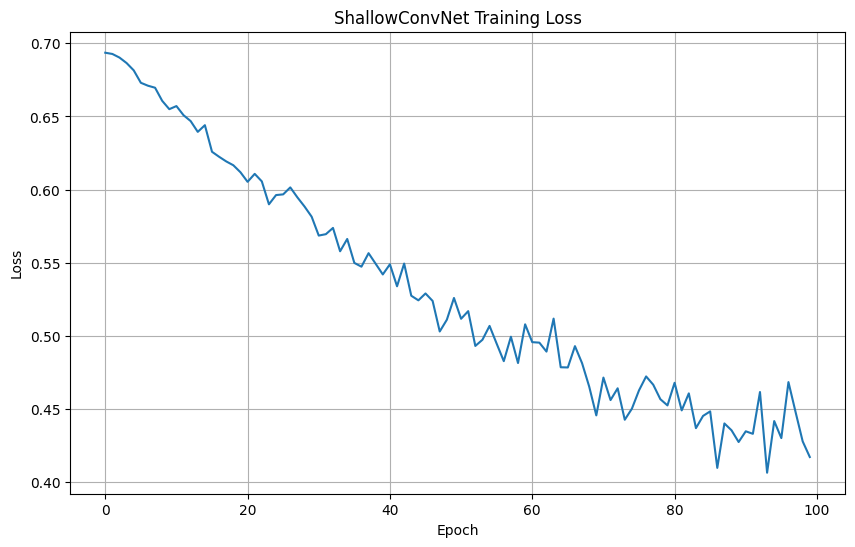


=== SHALLOW CONVNET PERFORMANCE SUMMARY ===
ShallowConvNet Accuracy:           0.461


In [9]:
# Define a simple ShallowConvNet architecture for EEG
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class ShallowConvNet(nn.Module):
    def __init__(self, n_channels, n_samples, n_classes):
        super(ShallowConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 40, (1, 13), padding=(0, 6), bias=False)
        self.conv2 = nn.Conv2d(40, 40, (n_channels, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(40)
        self.pool = nn.AvgPool2d(kernel_size=(1, 35), stride=(1, 7))
        self.dropout = nn.Dropout(0.5)
        self.elu = nn.ELU()
        self._n_samples = n_samples
        self.fc = nn.Linear(self._get_flattened_size(n_channels, n_samples), n_classes)

    def _get_flattened_size(self, n_channels, n_samples):
        # Calculate the size after conv/pool for the FC layer
        with torch.no_grad():
            x = torch.zeros(1, 1, n_channels, n_samples)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.bn1(x)
            x = self.elu(x)
            x = self.pool(x)
            x = self.dropout(x)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        # x shape: (batch, 1, n_channels, n_samples)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.elu(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Set parameters
window_size = 256
num_channels = 64
num_classes = len(set(y_resampled))
batch_size = 32
learning_rate = 0.001
epochs = 100

# Prepare EEG data (ensure correct shape: samples, 1, channels, samples)
eeg_data = X_resampled[:, :, :num_channels]  # shape: (N, window_size, num_channels)
eeg_labels = y_resampled

# Convert to torch tensors and reshape
eeg_data_tensor = torch.tensor(eeg_data, dtype=torch.float32).permute(0, 2, 1).unsqueeze(1)  # (N, 1, C, T)
eeg_labels_tensor = torch.tensor(eeg_labels, dtype=torch.long)

# Split into train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    eeg_data_tensor, eeg_labels_tensor, test_size=0.2, random_state=42, stratify=eeg_labels_tensor
)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ShallowConvNet(num_channels, window_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    accuracy = 100 * correct / total
    return accuracy, all_predictions, all_targets

accuracy, y_pred_shallow, y_true_shallow = evaluate_model(model, test_loader, device)

print(f"\nShallowConvNet Accuracy: {accuracy:.3f}%")
from sklearn.metrics import classification_report, confusion_matrix
print("\nShallowConvNet Classification Report:")
print(classification_report(y_true_shallow, y_pred_shallow))
print("\nShallowConvNet Confusion Matrix:")
print(confusion_matrix(y_true_shallow, y_pred_shallow))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('ShallowConvNet Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print("\n" + "="*50)
print("=== SHALLOW CONVNET PERFORMANCE SUMMARY ===")
print("="*50)
print(f"ShallowConvNet Accuracy:           {accuracy/100:.3f}")


In [ ]:
import torch
import numpy as np
from braindecode.models import EEGNet
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import matplotlib.pyplot as plt

# Prepare EEGNet data
# Assume X_resampled: (N, window_size, num_channels), y_resampled: (N,)
# EEGNet expects input shape: (batch, 1, n_chans, n_times)
# So we need to transpose and add channel dimension

# Set EEGNet parameters based on your data
# Transpose to (N, n_chans, n_times)
num_channels = 64
eeg_data = X_resampled[:, :, :num_channels]  # (N, window_size, num_channels)
eeg_data = np.transpose(eeg_data, (0, 2, 1))  # (N, num_channels, window_size)
eeg_labels = y_resampled

# Add channel dimension for PyTorch Conv2d: (N, 1, n_chans, n_times)
eeg_data_reshaped = eeg_data[:, np.newaxis, :, :]  # (N, 1, n_chans, n_times)

# Split the data
X_train_eegnet, X_test_eegnet, y_train_eegnet, y_test_eegnet = train_test_split(
    eeg_data_reshaped, eeg_labels, test_size=0.2, random_state=42, stratify=eeg_labels
)

# Convert to torch tensors
X_train_eegnet = torch.tensor(X_train_eegnet, dtype=torch.float32)
X_test_eegnet = torch.tensor(X_test_eegnet, dtype=torch.float32)
y_train_eegnet = torch.tensor(y_train_eegnet, dtype=torch.long)
y_test_eegnet = torch.tensor(y_test_eegnet, dtype=torch.long)

# DataLoader
batch_size = 32
train_dataset_eegnet = TensorDataset(X_train_eegnet, y_train_eegnet)
test_dataset_eegnet = TensorDataset(X_test_eegnet, y_test_eegnet)
train_loader_eegnet = DataLoader(train_dataset_eegnet, batch_size=batch_size, shuffle=True)
test_loader_eegnet = DataLoader(test_dataset_eegnet, batch_size=batch_size, shuffle=False)

# Set model parameters
n_chans = X_train_eegnet.shape[2]  # number of EEG channels
n_times = X_train_eegnet.shape[3]  # number of time samples
n_outputs = len(np.unique(y_train_eegnet.numpy()))  # number of classes

# Instantiate EEGNet model
eegnet_model = EEGNet(
    n_chans=n_chans,
    n_outputs=n_outputs,
    n_times=n_times,
    F1=8,
    D=2,
    F2=None,  # default is F1*D
    kernel_length=64,
    depthwise_kernel_length=16,
    pool1_kernel_size=4,
    pool2_kernel_size=8,
    final_conv_length="auto",
    drop_prob=0.25,
    activation=nn.ELU,
    batch_norm_momentum=0.01,
    batch_norm_affine=True,
    batch_norm_eps=1e-3,
    conv_spatial_max_norm=1,
    final_layer_with_constraint=False,
    norm_rate=0.25,
)

eegnet_model = eegnet_model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eegnet_model.parameters(), lr=0.001)

# Train the model
def train_model_eegnet(model, train_loader, criterion, optimizer, device, epochs=200):
    model.train()
    train_losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * data.size(0)
        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    return train_losses

print("Training EEGNet...")
eegnet_train_losses = train_model_eegnet(eegnet_model, train_loader_eegnet, criterion, optimizer, device, epochs=200)

# Evaluate the model
def evaluate_model_eegnet(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    accuracy = 100 * correct / total
    return accuracy, all_predictions, all_targets

eegnet_accuracy, y_pred_eegnet, y_true_eegnet = evaluate_model_eegnet(eegnet_model, test_loader_eegnet, device)

print(f"\nEEGNet Accuracy: {eegnet_accuracy:.3f}%")
print("\nEEGNet Classification Report:")
print(classification_report(y_true_eegnet, y_pred_eegnet))
print("\nEEGNet Confusion Matrix:")
print(confusion_matrix(y_true_eegnet, y_pred_eegnet))

plt.figure(figsize=(10, 6))
plt.plot(eegnet_train_losses)
plt.title('EEGNet Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print("\n" + "="*50)
print("=== EEGNET PERFORMANCE SUMMARY ===")
print("="*50)
print(f"EEGNet Accuracy:           {eegnet_accuracy/100:.3f}")


NameError: name 'X_train' is not defined

In [15]:
from braindecode.datasets import MOABBDataset

subject_id = 3
# Load the dataset
dataset = BNCI2014_001()

import numpy as np

from braindecode.preprocessing import (
    Preprocessor,
    exponential_moving_standardize,
    preprocess,
)

low_cut_hz = 4.0  # low cut frequency for filtering
high_cut_hz = 38.0  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(
        lambda data, factor: np.multiply(data, factor),  # Convert from V to uV
        factor=1e6,
    ),
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(
        exponential_moving_standardize,  # Exponential moving standardization
        factor_new=factor_new,
        init_block_size=init_block_size,
    ),
]

# Preprocess the data
preprocess(dataset, preprocessors, n_jobs=-1)

from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info["sfreq"]
assert all([ds.raw.info["sfreq"] == sfreq for ds in dataset.datasets])
# Calculate the window start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to
# define how windows should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

splitted = windows_dataset.split("session")
train_set = splitted["0train"]  # Session train
test_set = splitted["1test"]  # Session evaluation

/gpfs1/pi/djangraw/hsun11/miniconda3/envs/iclr26/lib/python3.12/site-packages/braindecode/preprocessing/preprocess.py:71: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn("Preprocessing choices with lambda functions cannot be saved.")


AttributeError: 'BNCI2014_001' object has no attribute 'datasets'

# EEGNet

In [ ]:
from codecs import raw_unicode_escape_decode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch
import mne
from sklearn.pipeline import make_pipeline
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from braindecode.util import set_random_seeds
from skorch.callbacks import LRScheduler
from braindecode.datasets import BaseConcatDataset, BaseDataset
from braindecode.preprocessing import create_fixed_length_windows


# Transpose to (N, n_chans, n_times)
num_channels = 64
eeg_data = X_resampled[:, :, :num_channels]  # (N, window_size, num_channels)
eeg_data = np.transpose(eeg_data, (0, 2, 1))  # (N, num_channels, window_size)
eeg_labels = np.array(y_resampled, dtype=int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    eeg_data, eeg_labels, test_size=0.2, random_state=42, stratify=eeg_labels
)

# Create datasets
sampling_freq = 256  # in Hertz
info = mne.create_info(num_channels, sfreq=sampling_freq)
datasets = []
for i in range(len(X_train)):
    raw = mne.io.RawArray(X_train[i], info, verbose=False)
    description = pd.Series(data=[y_train[i], 'train'], index=["target", "session"])
    datasets.append(BaseDataset(raw, description, target_name="target"))

for j in range(len(X_test)):
    raw = mne.io.RawArray(X_test[j], info, verbose=False)
    description = pd.Series(data=[y_test[j], 'test'], index=["target", "session"])
    datasets.append(BaseDataset(raw, description, target_name="target"))
datasets = BaseConcatDataset(datasets)

# Set up GPU if it is there
cuda = torch.cuda.is_available() 
device = "cuda" if cuda else "cpu"

# Set random seed to be able to reproduce results
seed = 42
set_random_seeds(seed=seed, cuda=cuda)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# define model
model = EEGNet(n_chans=64, n_outputs=2, n_times=window_size)
# print(model)
if cuda:
    model.cuda()

# Splitting windowed data into train, valid and test subsets.
splits = datasets.split("session")
train_set = splits["train"]
# valid_set = splits["valid"]
test_set = splits["test"]

# define training hyperparameters
lr = 0.0625 * 0.1
weight_decay = 0
batch_size = 32
n_epochs = 30
patience = 3

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    verbose=1,  # Not printing the results for each epoch
    device=device,
    classes=list(range(2)),
    max_epochs=n_epochs,
)

# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
# clf.fit(train_set, y=None)

# # evaluated the model after training
y_test_ = test_set.get_metadata().target
# test_acc = clf.score(test_set, y=y_test)
# print(f"Test acc: {(test_acc * 100):.2f}%")



/gpfs1/pi/djangraw/hsun11/miniconda3/envs/iclr26/lib/python3.12/site-packages/braindecode/preprocessing/windowers.py:984: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


# Band Power Analysis

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd

eeg_data = X_resampled[:, :, :64]  
eeg_data = np.transpose(eeg_data, (0, 2, 1))  # (N, num_channels, window_size)

def compute_band_power(data, fs=256, window_size=64):
    """
    Compute band power for different frequency bands over 64-sample windows.
    
    Parameters:
    -----------
    data : array-like, shape (n_samples, n_channels) or (n_channels, n_samples)
        EEG data
    fs : int, default=256
        Sampling frequency in Hz
    window_size : int, default=64
        Window size for analysis
        
    Returns:
    --------
    band_powers : dict
        Dictionary containing power for each frequency band
    """
    
    # Define frequency bands (in Hz)
    bands = {
        'delta': (1, 4),
        'theta': (4, 8), 
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    # Ensure data is in the right format (samples, channels)
    if data.shape[0] < data.shape[1]:
        data = data.T
    
    n_samples, n_channels = data.shape
    n_windows = n_samples // window_size
    
    # Initialize results dictionary
    band_powers = {band: np.zeros((n_windows, n_channels)) for band in bands.keys()}
    
    for i in range(n_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        window_data = data[start_idx:end_idx, :]
        
        for ch in range(n_channels):
            # Compute power spectral density using Welch's method
            freqs, psd = signal.welch(window_data[:, ch], fs=fs, nperseg=window_size, 
                                    noverlap=window_size//2, nfft=window_size)
            
            # Compute band power for each frequency band
            for band_name, (low_freq, high_freq) in bands.items():
                # Find frequency indices for the band
                freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
                # Compute power in the band (integrate PSD)
                band_power = np.trapz(psd[freq_mask], freqs[freq_mask])
                band_powers[band_name][i, ch] = band_power
    
    return band_powers, freqs, n_windows

# Test with the existing EEG data
print("Computing band powers for EEG data...")
print(f"EEG data shape: {X_resampled.shape}")

# Extract EEG data (first 64 channels)
eeg_data = X_resampled[:, :, :64]  # Shape: (n_samples, window_size, n_channels)

# Take first sample for demonstration
sample_eeg = eeg_data[0]  # Shape: (window_size, n_channels)
print(f"Sample EEG shape: {sample_eeg.shape}")

# Compute band powers
band_powers, freqs, n_windows = compute_band_power(sample_eeg, fs=256, window_size=64)

print(f"\nComputed band powers for {n_windows} windows")
print("Band power shapes:")
for band_name, powers in band_powers.items():
    print(f"  {band_name}: {powers.shape}")
    print(f"  {band_name} mean power: {np.mean(powers):.6f}")


Computing band powers for EEG data...
EEG data shape: (2778, 64, 70)
Sample EEG shape: (64, 64)

Computed band powers for 1 windows
Band power shapes:
  delta: (1, 64)
  delta mean power: 0.000000
  theta: (1, 64)
  theta mean power: 0.000000
  alpha: (1, 64)
  alpha mean power: 0.000000
  beta: (1, 64)
  beta mean power: 0.000000
  gamma: (1, 64)
  gamma mean power: 0.000000


Computing band powers for multiple EEG samples...

Band power statistics across samples:
       delta         theta         alpha          beta         gamma
count   10.0  1.000000e+01  1.000000e+01  1.000000e+01  1.000000e+01
mean     0.0  8.402264e-12  7.663227e-12  8.241280e-12  1.338005e-12
std      0.0  3.504721e-12  3.779644e-12  4.117985e-12  4.665638e-13
min      0.0  3.968588e-12  2.067365e-12  3.867693e-12  7.547245e-13
25%      0.0  5.412830e-12  4.942639e-12  6.215720e-12  1.045671e-12
50%      0.0  8.120068e-12  7.446441e-12  6.889826e-12  1.224786e-12
75%      0.0  1.065002e-11  1.100811e-11  9.116929e-12  1.457018e-12
max      0.0  1.382161e-11  1.267553e-11  1.870064e-11  2.268859e-12


/tmp/ipykernel_2301298/558727434.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([all_band_powers[band] for band in all_band_powers.keys()],


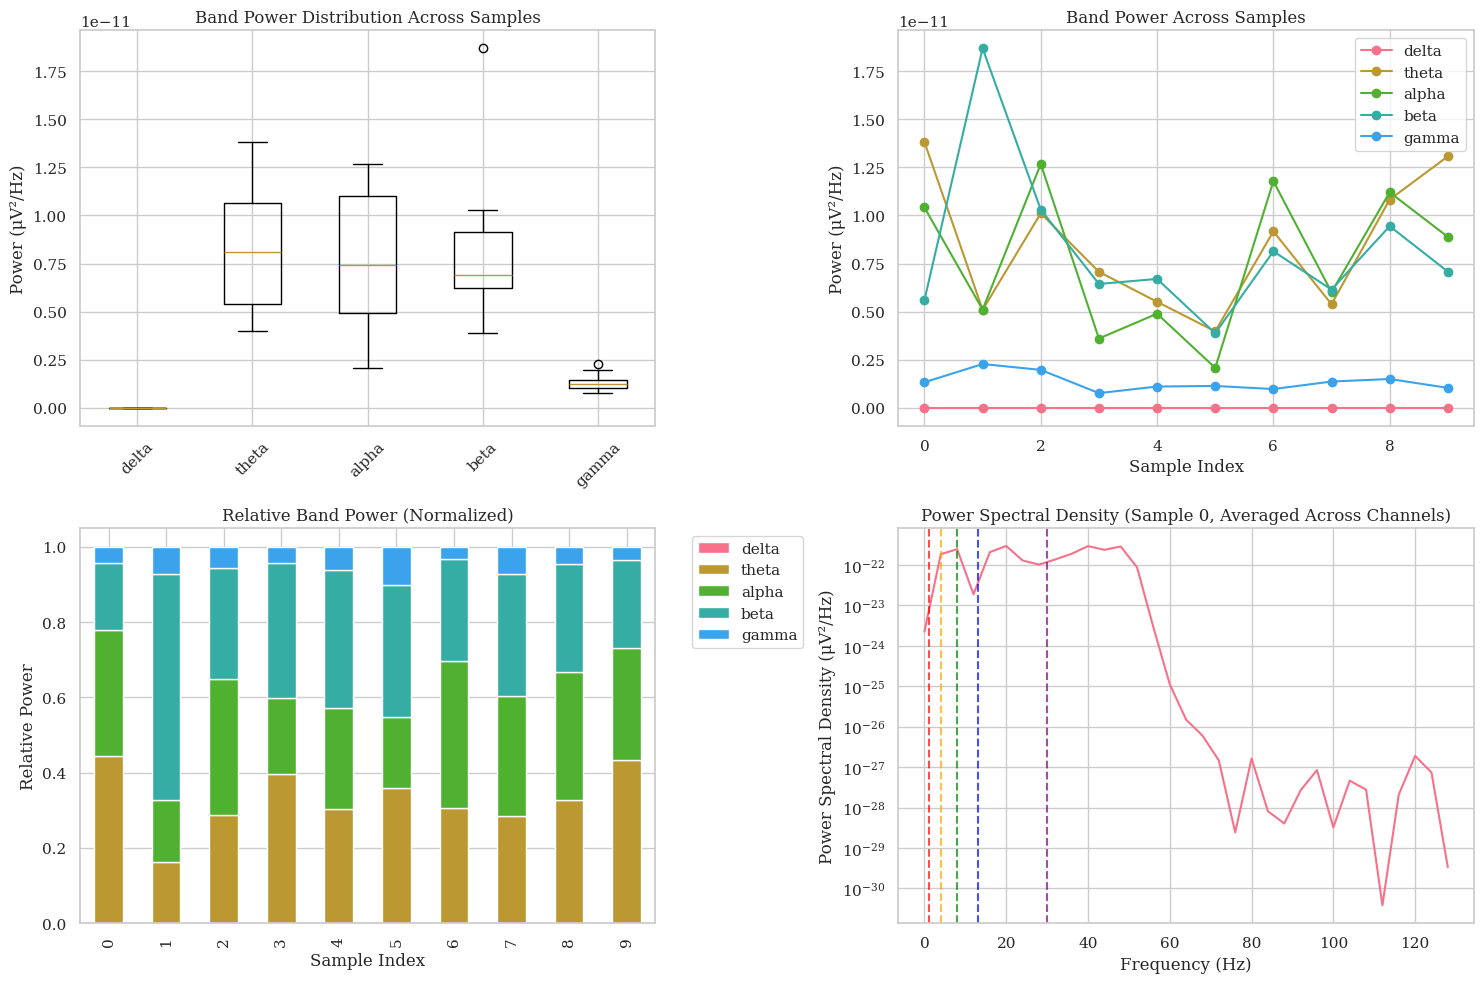


Analyzed 10 samples with 64-sample windows
Band frequency ranges:
  delta: 1-4 Hz
  theta: 4-8 Hz
  alpha: 8-13 Hz
  beta: 13-30 Hz
  gamma: 30-50 Hz


In [16]:
# Compute band powers for multiple samples and visualize results
print("Computing band powers for multiple EEG samples...")

# Compute band powers for first 10 samples
n_samples_to_analyze = min(10, len(eeg_data))
all_band_powers = {band: [] for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}

for i in range(n_samples_to_analyze):
    sample_eeg = eeg_data[i]  # Shape: (window_size, n_channels)
    band_powers, freqs, n_windows = compute_band_power(sample_eeg, fs=256, window_size=64)
    
    # Average across channels and windows for this sample
    for band_name, powers in band_powers.items():
        mean_power = np.mean(powers)
        all_band_powers[band_name].append(mean_power)

# Create DataFrame for easy analysis
band_power_df = pd.DataFrame(all_band_powers)
band_power_df.index.name = 'Sample'

print("\nBand power statistics across samples:")
print(band_power_df.describe())

# Visualize band powers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Band power distribution
axes[0, 0].boxplot([all_band_powers[band] for band in all_band_powers.keys()], 
                   labels=list(all_band_powers.keys()))
axes[0, 0].set_title('Band Power Distribution Across Samples')
axes[0, 0].set_ylabel('Power (μV²/Hz)')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Band power across samples
for band_name, powers in all_band_powers.items():
    axes[0, 1].plot(powers, marker='o', label=band_name)
axes[0, 1].set_title('Band Power Across Samples')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Power (μV²/Hz)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Relative band power (normalized)
normalized_powers = band_power_df.div(band_power_df.sum(axis=1), axis=0)
normalized_powers.plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Relative Band Power (Normalized)')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Relative Power')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: Power spectral density for one sample
sample_eeg = eeg_data[0]  # First sample
# Average across channels
avg_signal = np.mean(sample_eeg, axis=1)
freqs_psd, psd = signal.welch(avg_signal, fs=256, nperseg=64, noverlap=32, nfft=64)

axes[1, 1].semilogy(freqs_psd, psd)
axes[1, 1].set_title('Power Spectral Density (Sample 0, Averaged Across Channels)')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Power Spectral Density (μV²/Hz)')
axes[1, 1].grid(True)

# Add vertical lines for band boundaries
band_boundaries = [1, 4, 8, 13, 30, 50]
colors = ['red', 'orange', 'green', 'blue', 'purple']
for i, freq in enumerate(band_boundaries[:-1]):
    axes[1, 1].axvline(freq, color=colors[i], linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\nAnalyzed {n_samples_to_analyze} samples with {window_size}-sample windows")
print("Band frequency ranges:")
bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 50)}
for band_name, (low, high) in bands.items():
    print(f"  {band_name}: {low}-{high} Hz")


Extracting band power features for machine learning...
Processing 2778 samples...

Extracted features shape: (2778, 389)
Number of features: 389
Feature categories:
  - Band power per channel: 320 features
  - Relative band power: 5 features
  - Total power per channel: 64 features

First 10 feature names:
  0: delta_power_ch00
  1: delta_power_ch01
  2: delta_power_ch02
  3: delta_power_ch03
  4: delta_power_ch04
  5: delta_power_ch05
  6: delta_power_ch06
  7: delta_power_ch07
  8: delta_power_ch08
  9: delta_power_ch09

Last 10 feature names:
  379: total_power_ch54
  380: total_power_ch55
  381: total_power_ch56
  382: total_power_ch57
  383: total_power_ch58
  384: total_power_ch59
  385: total_power_ch60
  386: total_power_ch61
  387: total_power_ch62
  388: total_power_ch63

Feature statistics:
  Mean: 0.002571
  Std: 0.028703
  Min: 0.000000
  Max: 0.720087


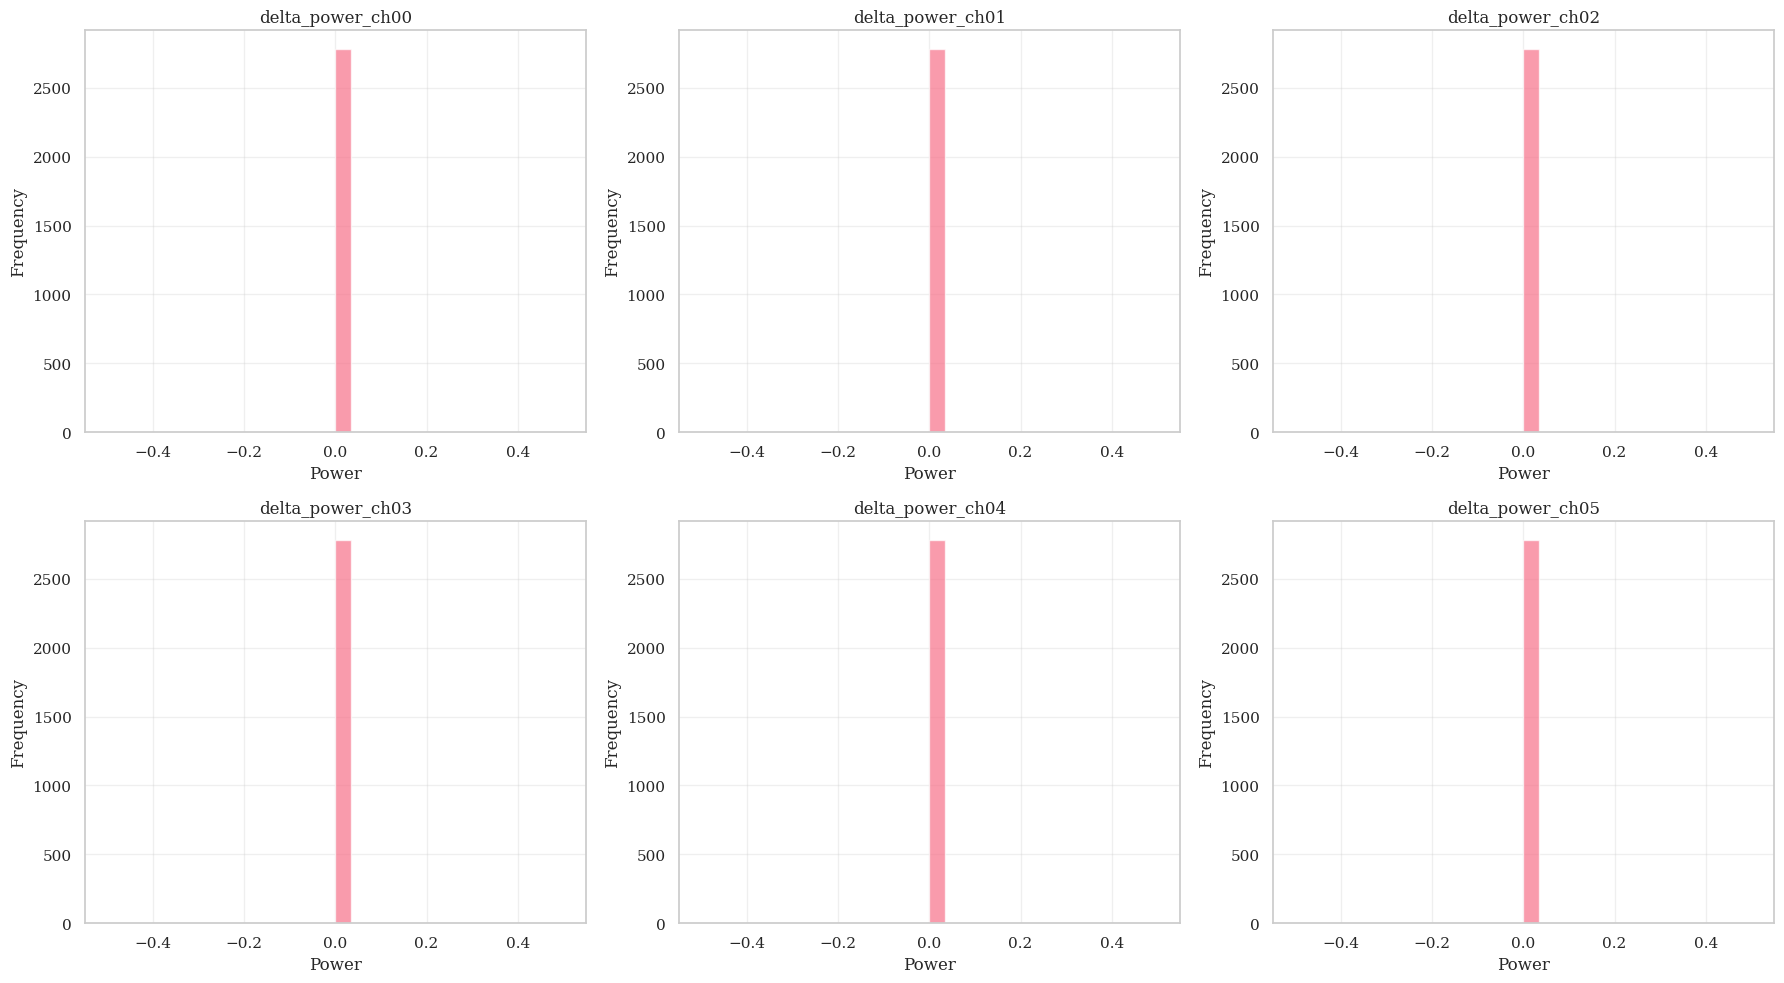


Band power features extracted successfully!
These features can be used as input to machine learning models.
Shape: (n_samples=2778, n_features=389)


In [17]:
# Create band power features for machine learning
def extract_band_power_features(eeg_data, fs=256, window_size=64):
    """
    Extract band power features from EEG data for machine learning.
    
    Parameters:
    -----------
    eeg_data : array-like, shape (n_samples, window_size, n_channels)
        EEG data
    fs : int, default=256
        Sampling frequency in Hz
    window_size : int, default=64
        Window size for analysis
        
    Returns:
    --------
    features : array, shape (n_samples, n_features)
        Band power features for each sample
    feature_names : list
        Names of the features
    """
    
    n_samples, _, n_channels = eeg_data.shape
    bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
    
    # Initialize feature matrix
    # Features: [mean_power_per_band_per_channel, relative_power_per_band, total_power_per_channel]
    n_features = len(bands) * n_channels + len(bands) + n_channels
    features = np.zeros((n_samples, n_features))
    
    # Create feature names
    feature_names = []
    
    # Band power per channel features
    for band in bands:
        for ch in range(n_channels):
            feature_names.append(f'{band}_power_ch{ch:02d}')
    
    # Relative band power features (summed across channels)
    for band in bands:
        feature_names.append(f'{band}_relative_power')
    
    # Total power per channel
    for ch in range(n_channels):
        feature_names.append(f'total_power_ch{ch:02d}')
    
    for i in range(n_samples):
        sample_eeg = eeg_data[i]  # Shape: (window_size, n_channels)
        band_powers, _, _ = compute_band_power(sample_eeg, fs=fs, window_size=window_size)
        
        feature_idx = 0
        
        # Band power per channel
        for band in bands:
            powers = band_powers[band]  # Shape: (n_windows, n_channels)
            mean_powers = np.mean(powers, axis=0)  # Average across windows
            features[i, feature_idx:feature_idx+n_channels] = mean_powers
            feature_idx += n_channels
        
        # Relative band power (summed across channels and normalized)
        total_powers = []
        for band in bands:
            powers = band_powers[band]
            total_power = np.sum(np.mean(powers, axis=0))  # Sum across channels, avg across windows
            total_powers.append(total_power)
        
        # Normalize to get relative powers
        total_sum = sum(total_powers)
        if total_sum > 0:
            relative_powers = [p / total_sum for p in total_powers]
        else:
            relative_powers = [0] * len(bands)
        
        features[i, feature_idx:feature_idx+len(bands)] = relative_powers
        feature_idx += len(bands)
        
        # Total power per channel
        channel_totals = np.zeros(n_channels)
        for band in bands:
            powers = band_powers[band]
            channel_totals += np.mean(powers, axis=0)
        
        features[i, feature_idx:feature_idx+n_channels] = channel_totals
    
    return features, feature_names

# Extract band power features for the entire dataset
print("Extracting band power features for machine learning...")
print(f"Processing {len(eeg_data)} samples...")

band_power_features, feature_names = extract_band_power_features(eeg_data, fs=256, window_size=64)

print(f"\nExtracted features shape: {band_power_features.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Feature categories:")
print(f"  - Band power per channel: {5 * 64} features")
print(f"  - Relative band power: {5} features") 
print(f"  - Total power per channel: {64} features")

# Show some example features
print(f"\nFirst 10 feature names:")
for i, name in enumerate(feature_names[:10]):
    print(f"  {i}: {name}")

print(f"\nLast 10 feature names:")
for i, name in enumerate(feature_names[-10:], len(feature_names)-10):
    print(f"  {i}: {name}")

# Basic statistics
print(f"\nFeature statistics:")
print(f"  Mean: {np.mean(band_power_features):.6f}")
print(f"  Std: {np.std(band_power_features):.6f}")
print(f"  Min: {np.min(band_power_features):.6f}")
print(f"  Max: {np.max(band_power_features):.6f}")

# Visualize feature distributions for first few features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i in range(6):
    axes[i].hist(band_power_features[:, i], bins=30, alpha=0.7)
    axes[i].set_title(f'{feature_names[i]}')
    axes[i].set_xlabel('Power')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBand power features extracted successfully!")
print(f"These features can be used as input to machine learning models.")
print(f"Shape: (n_samples={band_power_features.shape[0]}, n_features={band_power_features.shape[1]})")


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

eeg_labels = np.array(y_resampled, dtype=int)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    band_power_features, eeg_labels, test_size=0.2, random_state=42, stratify=eeg_labels
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF kernel)": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

results = {}

# You can adjust n_components for PCA as needed (e.g., 0.95 for 95% variance, or an int)
pca_n_components = 0.95

for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca_n_components, random_state=42)),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

import pandas as pd
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print("\nSummary of model accuracies:")
print(results_df)


Logistic Regression Accuracy: 0.5971
              precision    recall  f1-score   support

           0       0.59      0.62      0.60       278
           1       0.60      0.58      0.59       278

    accuracy                           0.60       556
   macro avg       0.60      0.60      0.60       556
weighted avg       0.60      0.60      0.60       556


SVM (RBF kernel) Accuracy: 0.6079
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       278
           1       0.61      0.59      0.60       278

    accuracy                           0.61       556
   macro avg       0.61      0.61      0.61       556
weighted avg       0.61      0.61      0.61       556


Random Forest Accuracy: 0.5558
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       278
           1       0.56      0.55      0.55       278

    accuracy                           0.56       556
   macro avg       0.56

# Create Braindecode datasets

In [3]:
import os
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from braindecode.datasets import create_from_X_y
from sklearn.model_selection import train_test_split

# define data root
# this is the path to the ROAMM folder on local machine
roamm_root = r"/gpfs1/pi/djangraw/mindless_reading/ROAMM"
ml_data_root = os.path.join(roamm_root, 'subject_ml_data')
# define subject id
subject_id = 's10014'
subject_dir = os.path.join(ml_data_root, subject_id)
# load all runs for a subject
pkl_files = [f for f in os.listdir(subject_dir) if f.endswith('.pkl')]
df = pd.DataFrame()
for pkl_file in pkl_files:
    df_sub_single_run = pd.read_pickle(os.path.join(subject_dir, pkl_file))
    df_sub_single_run = df_sub_single_run[df_sub_single_run['first_pass_reading'] == 1]
    # convert bool col explicitly to avoid pandas warning
    for col in ['is_blink', 'is_saccade', 'is_fixation', 'is_mw', 'first_pass_reading']:
        df_sub_single_run[col] = df_sub_single_run[col] == True
    df = pd.concat([df, df_sub_single_run])

# normalize pupil size features
df['blink_interp_LPupil_norm'] = df['blink_interp_LPupil'] / df['blink_interp_LPupil'].median()
df['blink_interp_RPupil_norm'] = df['blink_interp_RPupil'] / df['blink_interp_RPupil'].median()

# define EEG and eye tracking features
ch_names = df.columns.tolist()[:64]  #first 64 columns are EEG channels
sfreq = 256
window_seconds = 0.5
# Downsample data using 1-second windows (fs = 256 Hz)
windowed_data = []
windowed_labels = []
window_size = int(sfreq * window_seconds)

# Process data in chunks of window_size
for i in range(0, len(df), window_size):
    window = df.iloc[i:i+window_size]
    # Skip if window is too small
    if len(window) < window_size:
        continue
    # Check if labels are consistent in this window
    labels_in_window = window['is_mw'].unique()
    if len(labels_in_window) > 1:
        # Skip windows with mixed labels
        continue

    # Extract features for this window: keep as 2D array (window_size x feature_number)
    eeg_data = window[ch_names].values
    windowed_data.append(eeg_data)
    # Use the consistent label
    windowed_labels.append(labels_in_window[0])

# Use RandomUnderSampler on flattened data, then recover 3D structure
windowed_data_flat = [w.flatten() for w in windowed_data]
undersampler = RandomUnderSampler(random_state=42)
X_resampled_flat, y_resampled = undersampler.fit_resample(windowed_data_flat, windowed_labels)
# Recover 3D array: (n_samples, window_size, n_features)
window_size = windowed_data[0].shape[0]
n_features = windowed_data[0].shape[1]
X_resampled = np.array(X_resampled_flat).reshape(-1, window_size, n_features)
X = np.transpose(X_resampled, (0, 2, 1))  # (N, num_channels, window_size)
y = np.array(y_resampled, dtype=int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# create braindecode datasets for training and testing
train_set = create_from_X_y(
    X_train,
    y_train,
    drop_last_window=False,
    sfreq=sfreq,
    ch_names=ch_names,
    window_stride_samples=window_size,
    window_size_samples=window_size
)

test_set = create_from_X_y(
    X_test,
    y_test,
    drop_last_window=False,
    sfreq=sfreq,
    ch_names=ch_names,
    window_stride_samples=window_size,
    window_size_samples=window_size
)



Creating RawArray with float64 data, n_channels=64, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.496 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.496 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.496 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.496 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.496 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.496 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.496 secs
Ready.
Creating RawArray with float64 data, n_channels=64, n_times=128
    Range : 0 ... 127 =      0.000 ...     0.496 secs
Ready.


# Call EEGNet

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.5005        0.6995  0.0063  1.9784
      2            0.5005        0.6950  0.0062  1.2079
      3            0.5005        0.6937  0.0062  1.0158
      4            0.5005        0.6949  0.0062  1.3091
      5            0.4995        0.6942  0.0062  1.0287
      6            0.5005        0.6974  0.0062  1.2660
      7            0.4995        0.6926  0.0062  1.0107
      8            0.4995        0.6940  0.0062  1.3120
      9            0.5495        0.6873  0.0061  1.0005
     10            0.5005        0.6886  0.0061  1.2009
     11            0.5005        0.6874  0.0061  1.1525
     12            0.4995        0.6891  0.0061  1.1186
     13            0.4995        0.6890  0.0060  1.2670
     14            0.4995        0.6866  0.0060  1.2098
     15            0.5060        0.6819  0.0059  1.4174
     16            0.5005        0.6755  0.0059 

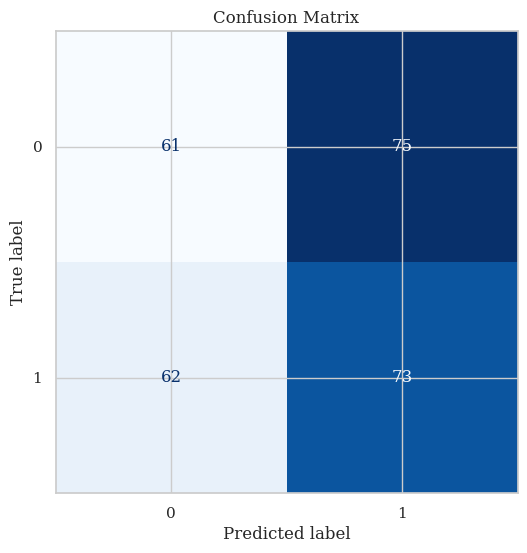


Classification Report:
              precision    recall  f1-score   support

           0     0.4959    0.4485    0.4710       136
           1     0.4932    0.5407    0.5159       135

    accuracy                         0.4945       271
   macro avg     0.4946    0.4946    0.4935       271
weighted avg     0.4946    0.4945    0.4934       271

Accuracy: 0.4945
Weighted F1 Score: 0.4934


In [4]:
from codecs import raw_unicode_escape_decode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from sklearn.pipeline import make_pipeline
from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from braindecode.models import EEGNet, ATCNet
from braindecode.util import set_random_seeds
from skorch.callbacks import LRScheduler
from braindecode.datasets import BaseConcatDataset, BaseDataset
from braindecode.preprocessing import create_fixed_length_windows

# Set up GPU if it is there
cuda = torch.cuda.is_available() 
device = "cuda" if cuda else "cpu"

# Set random seed to be able to reproduce results
seed = 42
set_random_seeds(seed=seed, cuda=cuda)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# define model
model = EEGNet(n_chans=64, n_outputs=2, n_times=window_size)
# model = ATCNet(n_chans=64, n_outputs=2, input_window_seconds=window_seconds, sfreq=sfreq, chs_info=ch_names, n_times=window_size)
# print(model)
if cuda:
    model.cuda()

# define training hyperparameters
lr = 0.0625 * 0.1
weight_decay = 0
batch_size = 32
n_epochs = 100
patience = 3

clf = EEGClassifier(
    model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    verbose=1,  # Not printing the results for each epoch
    device=device,
    classes=list(range(2)),
    max_epochs=n_epochs,
)

# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=None)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Predict labels
y_pred = clf.predict(test_set)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Print additional metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")


# PSD

In [1]:
import os
import numpy as np
import mne

# define data root
# this is the path to the ROAMM folder on local machine
roamm_root = r"/gpfs1/pi/djangraw/mindless_reading/ROAMM"
ml_data_root = os.path.join(roamm_root, 'subject_ml_data')
# define subject id
subject_id = 's10014'
subject_dir = os.path.join(ml_data_root, subject_id, 'window_datasets')
# load single data
data = np.load(os.path.join(subject_dir, 's10014_256windowed_data.npy'))
labels = np.load(os.path.join(subject_dir, 's10014_256windowed_labels.npy'))
col_name = np.load(os.path.join(subject_dir, 's10014_col_names.npy'))
sfreq = 256

# get the 64-channel eeg data (first 64 cols)
eeg_data = data[:, :64, :]
eeg_data = eeg_data.astype(np.float64)
psds, freqs = mne.time_frequency.psd_array_multitaper(eeg_data, sfreq, fmax=50, remove_dc=False)



    Using multitaper spectrum estimation with 7 DPSS windows


Creating individual channel plots...


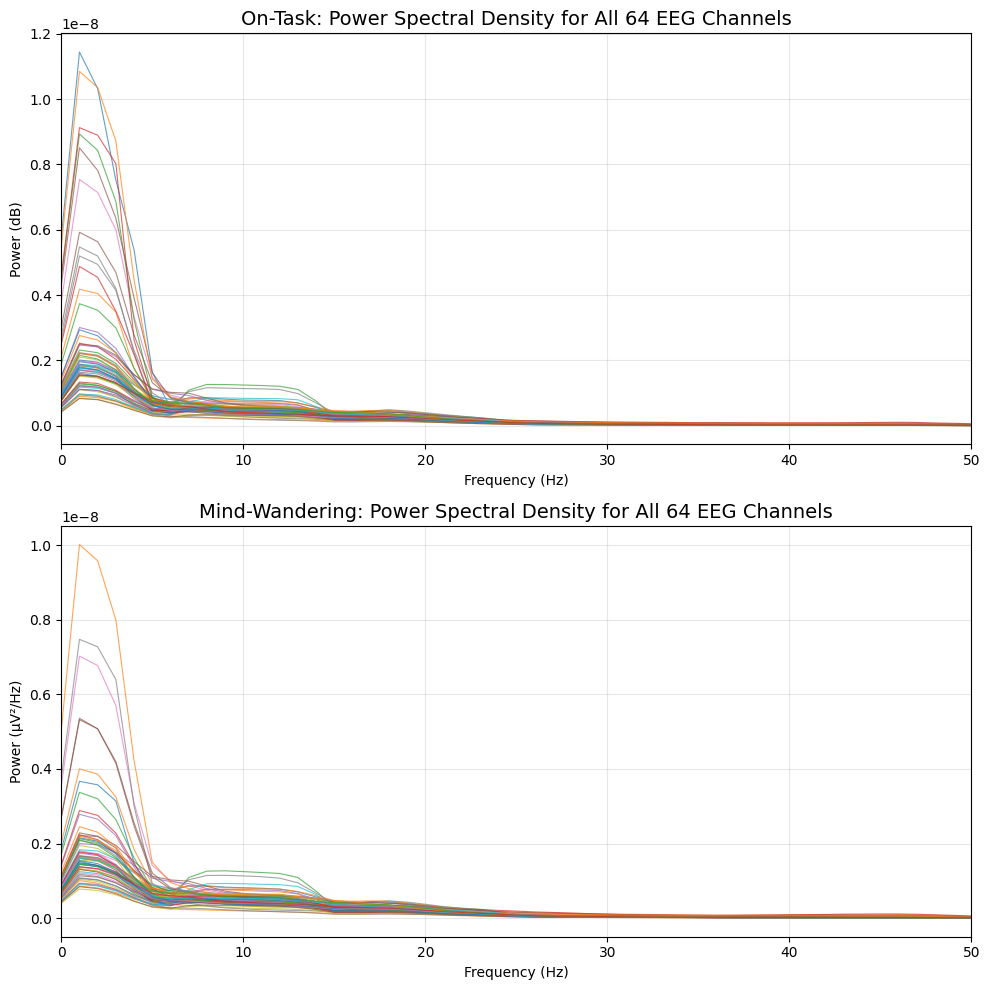

In [2]:
import matplotlib.pyplot as plt

# plot each channel PSD for on-task and mind-wandering
labels = labels.astype(bool)
psds_ot = np.mean(psds[~labels], axis=0)
psds_mw = np.mean(psds[labels], axis=0)

# Convert to dB (decibels)
# psds_ot_db = 10 * np.log10(psds_ot)
# psds_mw_db = 10 * np.log10(psds_mw)

print("Creating individual channel plots...")

# Create the plot with proper indexing
plt.figure(figsize=(10, 10))

# Plot on-task condition (all 64 channels)
plt.subplot(2, 1, 1)
# for ch_idx in range(psds_ot_db.shape[0]):  # Iterate over channels
#     plt.plot(freqs, psds_ot_db[ch_idx, :], alpha=0.7, linewidth=0.8)

for ch_idx in range(psds_ot.shape[0]):  # Iterate over channels
    plt.plot(freqs, psds_ot[ch_idx, :], alpha=0.7, linewidth=0.8)

plt.title('On-Task: Power Spectral Density for All 64 EEG Channels', fontsize=14)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')
plt.grid(True, alpha=0.3)
plt.xlim(0, 50)

# Plot mind-wandering condition (all 64 channels)
plt.subplot(2, 1, 2)
# for ch_idx in range(psds_mw_db.shape[0]):  # Iterate over channels
#     plt.plot(freqs, psds_mw_db[ch_idx, :], alpha=0.7, linewidth=0.8)

for ch_idx in range(psds_mw.shape[0]):  # Iterate over channels
    plt.plot(freqs, psds_mw[ch_idx, :], alpha=0.7, linewidth=0.8)

plt.title('Mind-Wandering: Power Spectral Density for All 64 EEG Channels', fontsize=14)
plt.xlabel('Frequency (Hz)')
# plt.ylabel('Power (dB)')
plt.ylabel('Power (μV²/Hz)')
plt.grid(True, alpha=0.3)
plt.xlim(0, 50)

plt.tight_layout()
plt.show()

             

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM (RBF kernel)": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

results = {}

# You can adjust n_components for PCA as needed (e.g., 0.95 for 95% variance, or an int)
pca_n_components = 0.95

# Split the data
psds_flattened = psds.reshape(psds.shape[0], -1)
# convert to dB
psds_flattened = 10 * np.log10(psds_flattened)
X_train, X_test, y_train, y_test = train_test_split(
    psds_flattened, labels, test_size=0.2, random_state=42, stratify=labels
)

for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca_n_components, random_state=42)),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

import pandas as pd
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print("\nSummary of model accuracies:")
print(results_df)


Logistic Regression Accuracy: 0.6333
              precision    recall  f1-score   support

       False       0.67      0.53      0.59        60
        True       0.61      0.73      0.67        60

    accuracy                           0.63       120
   macro avg       0.64      0.63      0.63       120
weighted avg       0.64      0.63      0.63       120


SVM (RBF kernel) Accuracy: 0.6167
              precision    recall  f1-score   support

       False       0.65      0.50      0.57        60
        True       0.59      0.73      0.66        60

    accuracy                           0.62       120
   macro avg       0.62      0.62      0.61       120
weighted avg       0.62      0.62      0.61       120


Random Forest Accuracy: 0.5833
              precision    recall  f1-score   support

       False       0.59      0.55      0.57        60
        True       0.58      0.62      0.60        60

    accuracy                           0.58       120
   macro avg       0.58